# WOfS and MrVBF Check  <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[ga_ls8c_wofs_2](https://explorer.digitalearth.africa/ga_ls8c_wofs_2),
[ga_ls8c_wofs_2_summary ](https://explorer.digitalearth.africa/ga_ls8c_wofs_2_summary)

## Background
The [Water Observations from Space (WOfS)](https://www.ga.gov.au/scientific-topics/community-safety/flood/wofs/about-wofs) is a derived product from Landsat 8 satellite observations as part of provisional Landsat 8 Collection 2 surface reflectance and shows surface water detected in Africa.
Individual water classified images are called Water Observation Feature Layers (WOFLs), and are created in a 1-to-1 relationship with the input satellite data. 
Hence there is one WOFL for each satellite dataset processed for the occurrence of water.

The data in a WOFL is stored as a bit field. This is a binary number, where each digit of the number is independantly set or not based on the presence (1) or absence (0) of a particular attribute (water, cloud, cloud shadow etc). In this way, the single decimal value associated to each pixel can provide information on a variety of features of that pixel. 
For more information on the structure of WOFLs and how to interact with them, see [Water Observations from Space](../Datasets/Water_Observations_from_Space.ipynb) and [Applying WOfS bitmasking](../Frequently_used_code/Applying_WOfS_bitmasking.ipynb) notebooks.

## Description
This notebook explains how you can perform a check between slope, MrVBF in cog format and WOfS summary. 

The notebook demonstrates how to:

1. the DEM derivatives are all in EPSG:6933, because slope can only be meaningfully measured in meter unit projection
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

After finishing the analysis, you can modify some values in the "Analysis parameters" cell and re-run the analysis to load WOFLs for a different location or time period.

### Load packages
Import Python packages that are used for the analysis.

In [2]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

#for parallelisation 
from multiprocessing import Pool, Manager
import multiprocessing as mp
from tqdm import tqdm

In [3]:
from datacube.testutils.io import rio_slurp_xarray
from datacube.utils.geometry import GeoBox, box, CRS

In [4]:
#function for loading cog dataset 
def load_from_cog(url, x = None, y = None, resolution = None, output_crs = None, **kwargs):
    if 'crs' is kwargs: input_crs = CRS(crs)
    else: input_crs = CRS('EPSG:4326')
    gbox = box(x[0], y[0], x[1], y[1], crs = input_crs)
    # define output bounding box
    output_gbox = gbox.to_crs(crs=CRS(output_crs))
    # define output grid
    output_grid = GeoBox.from_geopolygon(output_gbox, resolution = resolution)
    return rio_slurp_xarray(url, gbox = output_grid)

### Connect to available products 
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [20]:
#loading MrVBF 
url_mrvbf = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_mrvbf_africa.tif"
mrvbf =  load_from_cog(url_mrvbf, x=(19.86,20.15), y=(-33.79,-33.67), resolution = (-30,30), output_crs = "EPSG:6933")

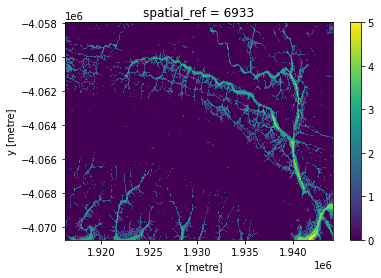

In [21]:
mrvbf.plot.imshow()

In [22]:
#loading Slope
url_slope = "https://deafrica-data.s3.amazonaws.com/ancillary/dem-derivatives/cog_slope_africa.tif"
slope = load_from_cog(url_slope, x=(19.86,20.15), y=(-33.79,-33.67), resolution = (-30,30), output_crs = "EPSG:6933")

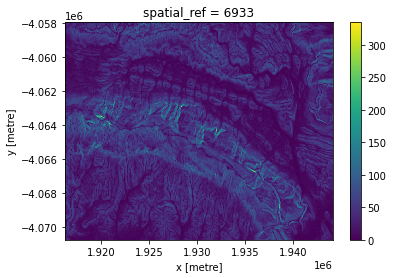

In [23]:
#seems to be the percentage but with also -9999 values 
slope.plot.imshow()

### Connect to datacube 

In [24]:
dc = datacube.Datacube()

In [25]:
#select the WOfS summary for that particular part in Ghana and compare 
# download the notebook as https://github.com/digitalearthafrica/deafrica-sandbox-notebooks/blob/mangroves-clean/Real_world_examples/Mangrove_analysis.ipynb
#select a few other locations and compare 

In [26]:
# Menindee lakes
query = {
    'x': (19.86,20.15),
    'y': (-33.79,-33.67),
    "time": ("2018-07", "2018-12"),
    "resolution": (-30, 30),
    "group_by": "solar_day",
}

In [27]:
standard = dc.load(product='ga_ls8c_wofs_2', output_crs = "EPSG:6933",**query)

In [28]:
#standard.count_wet.plot(vmax=1, vmin=0); None

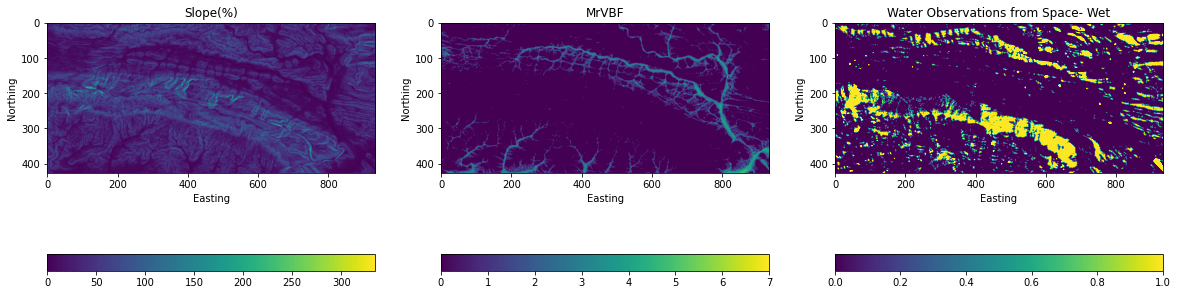

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for ax, ax2,ax3, x in zip(axes[:1],axes[1:2],axes[2:3],[standard.water]):
    wet = (x == 128).sum(axis=0)
    dry = (x == 0).sum(axis=0)
    clear = wet + dry
    freq = wet / clear
    p = ax.imshow(slope)
    p2 = ax2.imshow(mrvbf,vmin=0,vmax=7)
    p3 = ax3.imshow(wet,vmin=0,vmax=1)
plt.colorbar(p, ax=axes[:1], location='bottom');
plt.colorbar(p2, ax=axes[1:2], location='bottom'); 
plt.colorbar(p3, ax=axes[2:3], location='bottom'); 
ax.set(title = "Slope(%)", xlabel = "Easting", ylabel = "Northing");
ax2.set(title = "MrVBF", xlabel = "Easting", ylabel = "Northing");
ax3.set(title = "Water Observations from Space- Wet", xlabel = "Easting", ylabel="Northing");None

Plotting the WOfS along with identified MrVBF 

In [ ]:
print(datacube.__version__)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

## Tags
Browse all available tags on the DE Africa User Guide's [Tags Index](https://) (placeholder as this does not exist yet)

### Review for further development 
* the following cells were tested for the RCMRD dataset following query WOfS for both wet and clear but it didnt improve the timing compared to the previous code. 